In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [9]:
# Resistor values (Ohm)
R_1 = 100
R_2 = 20E3
R_3 = 47E3
R_4 = 200
R_5 = 2E3

# Capacitor values (F)
C_1 = 680E-12
C_2 = 0.22E-6
C_3 = 1E-9

def Z_c(C, f):
    """
    Capacitor impedance
    """
    
    return 1 / (2 * np.pi * f * C * complex(0, 1))


def VDG(Z_1, Z_2):
    """
    Gain factor for voltage divider Op-amp circuit
    """

    return (Z_1 + Z_2) / Z_1


def VDF(Z_1, Z_2):
    """
    Voltage divider circuit gain factor
    """

    return Z_1 / (Z_2 + Z_1)


def c_amp(f):
    """
    Final complex amplification factor for entire circuit
    """
    
    return VDG(R_1, 1/(1/R_2 + 1/Z_c(C_1, f))) * VDF(R_3, Z_c(C_2, f)) * VDG(R_4, 1/(1/R_5 + 1/Z_c(C_3, f)))


def amplification(c_amp):
    """
    Converts complex amplification factor to real amplification factor
    """
    
    return np.sqrt(c_amp * c_amp.conjugate())

def phase(c_amp):
    """
    Converts complex amplification factor to phase shift
    """

    # c_amp lies in Q1 of complex plane
    if c_amp.real >= 0 and c_amp.imag >= 0:
        return np.arctan(c_amp.imag / c_amp.real)
    
    # c_amp lies in Q2 of complex plane
    elif c_amp.real < 0 and c_amp.imag >= 0:
        return -np.pi + np.arctan(c_amp.imag / c_amp.real)
   
    # c_amp lies in Q3 of complex plane
    elif c_amp.real < 0 and c_amp.imag < 0:
        return np.arctan(c_amp.imag / c_amp.real) - np.pi

    # c_amp lies in Q4 of complex plane
    else:
        return np.arctan(c_amp.imag / c_amp.real)

In [10]:
V_1 = 50E-3
u_V_in = 1E-3
cR_1 = 120.26E3
cf_arr = np.array([])

for i in range(21):
    f = 10 ** (i * 0.25)
    ecR_2 = cR_1 / (amplification(c_amp(f)) / 2 - 1)
    cf_arr = np.append(cf_arr, round(f))
    print(round(ecR_2.real), round(f))


1702 1
955 2
543 3
318 6
200 10
144 18
121 32
113 56
110 100
109 178
109 316
109 562
109 1000
110 1778
113 3162
121 5623
144 10000
203 17783
338 31623
656 56234
1511 100000


In [61]:
def v_into_amp(V_in, R_1, R_2):
    return V_in * R_2 / (R_1 + R_2)


cR_2 = np.array([982.4, 982.4, 391.017, 391.017, 200.64, 150.241, 150.241, 120.543, 120.543,
                 120.543, 120.543, 120.543, 120.543, 120.543, 120.543, 120.543, 120.543,
                 120.543, 325.049, 392.225, 980.54])
obs_V_out = np.array([0.0512/2, 0.117/2, 0.0888/2, 0.227/2, 0.188/2, 0.206/2, 0.249/2, 0.217/2, 
                      0.228/2, 0.224/2, 0.223/2, 0.22/2, 0.22/2, 0.218/2, 0.211/2, 0.191/2,
                      0.153/2, 0.101/2, 0.158/2, 0.091/2, 0.0925/2])

V_in = v_into_amp(V_1, cR_1, cR_2)

G = obs_V_out / V_in

def fourier_series(x, a0, an, bn, T):
    series = a0 / 2  # Start with the constant term
    for n in range(1, len(an) + 1):
        series += an[n - 1] * np.cos(2 * np.pi * n * x / T) + bn[n - 1] * np.sin(2 * np.pi * n * x / T)
    return series

T = 10 ** 5

fourier_coeffs = np.fft.fft(G) / len(cf_arr)

# Split the coefficients into cosine (real) and sine (imaginary) parts
a0 = fourier_coeffs[0].real  # DC component (constant term)
an = 2 * fourier_coeffs[1:len(fourier_coeffs) // 2].real  # Cosine terms
bn = -2 * fourier_coeffs[1:len(fourier_coeffs) // 2].imag  # Sine terms

Text(0.5, 0, 'Frequency (Hz)')

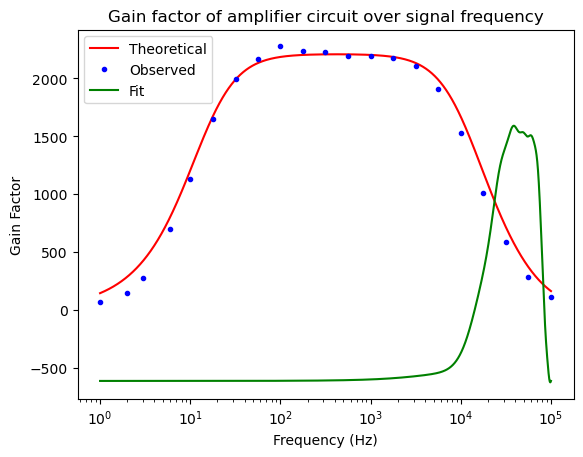

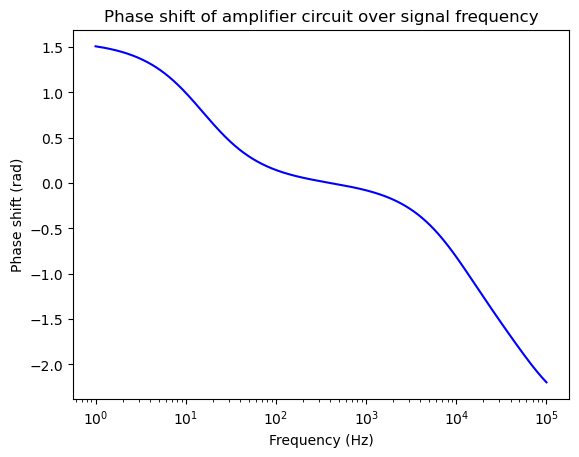

In [62]:
f_arr = np.logspace(0, 5, 5000)

amp_arr = []
phase_arr = []

for f in f_arr:
    amp_arr.append(amplification(c_amp(f)))
    phase_arr.append(phase(c_amp(f)))

fig0 = plt.figure(0)
ax0 = fig0.add_subplot()
ax0.set_xscale('log')
ax0.plot(f_arr, amp_arr, 'r')
ax0.set_title('Gain factor of amplifier circuit over signal frequency')
ax0.set_ylabel('Gain Factor')
ax0.set_xlabel('Frequency (Hz)')
ax0.plot(cf_arr, G, 'b.')
ax0.plot(f_arr, fourier_series(f_arr, a0, an, bn, T), 'g')
ax0.legend(['Theoretical', 'Observed', 'Fit'])

fig1 = plt.figure(1)
ax1 = fig1.add_subplot()
ax1.set_xscale('log')
ax1.plot(f_arr, phase_arr, 'b')
ax1.set_title('Phase shift of amplifier circuit over signal frequency')
ax1.set_ylabel('Phase shift (rad)')
ax1.set_xlabel('Frequency (Hz)')

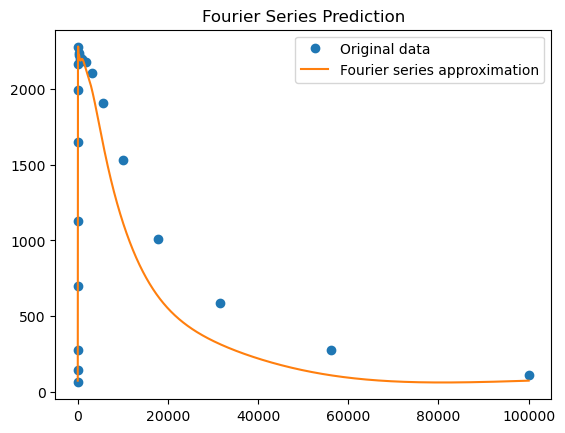

1379.4293982629035 [-1.14775581e+03 -2.71034465e+02  7.82112759e+01  3.34015307e+01
  2.35078763e-02 -4.26104914e+00  4.39899828e+00  9.71169813e+00
 -7.57295068e+00] [ 53.04007044  -0.66392375  -4.16168139 -12.52907953  -2.04761125
   5.75209866   1.89679473   7.75479979  10.5958652 ]


In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: let's create a sample signal using a sine wave
# Replace this with your actual data
t = cf_arr
y = G

def fourier_series(x, a0, an, bn, T):
    series = a0  # Start with the constant term
    for n in range(1, len(an) + 1):
        series += an[n - 1] * np.cos(2 * np.pi * n * np.log10(x) / T) + bn[n - 1] * np.sin(2 * np.pi * n * np.log10(x) / T)
    return series

T = 5

# Perform Fourier transform and extract coefficients
fourier_coeffs = np.fft.fft(y) / len(t)  # Normalize by number of points
frequencies = np.fft.fftfreq(len(t), d=(t[1] - t[0]))

# Split the coefficients into cosine (real) and sine (imaginary) parts
a0 = fourier_coeffs[0].real  # DC component (constant term)
an = 2 * fourier_coeffs[1:len(fourier_coeffs) // 2].real  # Cosine terms
bn = -2 * fourier_coeffs[1:len(fourier_coeffs) // 2].imag  # Sine terms

plt.plot(t, y, 'o', label='Original data')
plt.plot(f_arr, fourier_series(f_arr, a0, an, bn, T), label='Fourier series approximation')
plt.legend()
plt.title('Fourier Series Prediction')
plt.show()

print(a0, an, bn)